# Carga de datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = pd.read_csv("DelayedFlights.csv") # carga de datos
data.drop(["Unnamed: 0"], axis=1, inplace=True)


#Limpieza de datos
data.drop_duplicates(subset=["FlightNum", "Year", "Month", "DayofMonth", "CRSDepTime", "Origin", "Dest", "UniqueCarrier"], inplace=True)
data = data[
    (data["Cancelled"] == 0)
    & ~(data["ArrTime"].isnull())
    & ~(data["DepTime"].isnull())
    & (data["CRSElapsedTime"]>0)
    & ~(data["ArrDelay"].isnull())
    & ~(data["DepDelay"].isnull())
    ]
data.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


# Definición de nuevas columnas

Se definen las siguientes columnas:
- ArrDelay10, ArrDelay20, ArrDelay30 (todos int y binarios): se definen como 1 si el vuelo tuvo un delay en el arrival mayor a 10, 20 o 30 minutos respectivamente
- DepDelay10, DepDelay20, DepDelay20 (todos int y binarios): se definen como 1 si el vuelo tuvo un delay en el departure mayor a 10, 20 o 30 minutos respectivamente
- ArrHourBlock2, ArrHourBlock4 (str categóricas): separa la hora del arrival (recordar que es una hora en formato militar) en 2 bloques que pueden ser AM y PM o en 4 bloques que son madrugada, mañana, tarde y noche
- DepHourBlock2, DepHourBlock4 (str categóricas): separa la hora del departure (recordar que es una hora en formato militar) en 2 bloques que pueden ser AM y PM o en 4 bloques que son madrugada, mañana, tarde y noche


Las variables definidas en el primer y segundo punto permiten cuantificar de 3 formas diferentes si un vuelo tuvo o no un atraso (ya sea en el departure o en el arrival) considerables, lo cual permitirá poder **PREDECIR** en base a otras variables si un vuelo tendrá o no un atraso. Por otro lado, las variables definidas en el tercer y cuarto punto permiten separar en categorías horarias interpretables y así poder visualizar de mejor forma en qué momentos del día se obtienen mayores retrasos o delays.

In [3]:
# Atrasos de 10, 20 y 30 minutos
data["ArrDelay10"] = data["ArrDelay"].apply(lambda s: 1 if s>=10 else 0)
data["DepDelay10"] = data["DepDelay"].apply(lambda s: 1 if s>=10 else 0)
data["ArrDelay20"] = data["ArrDelay"].apply(lambda s: 1 if s>=20 else 0)
data["DepDelay20"] = data["DepDelay"].apply(lambda s: 1 if s>=20 else 0)
data["ArrDelay30"] = data["ArrDelay"].apply(lambda s: 1 if s>=30 else 0)
data["DepDelay30"] = data["DepDelay"].apply(lambda s: 1 if s>=30 else 0)

def bloque_horario4(time):
    if time>=0 and time<=600:
        return "Madrugada"
    elif time>600 and time<=1200:
        return "Mañana"
    elif time>1200 and time<=2000:
        return "Tarde"
    else:
        return "Noche"

data["DepHourBlock4"] = data["DepTime"].apply(bloque_horario4)
data["ArrHourBlock4"] = data["ArrTime"].apply(bloque_horario4)
data["DepHourBlock2"] = data["DepTime"].apply(lambda s: "AM" if s<=1200 else "PM")
data["ArrHourBlock2"] = data["ArrTime"].apply(lambda s: "AM" if s<=1200 else "PM")

Para los bloques horarios definidos, se puede ver que para 4 bloques el bloque de madrugada es minoritario en el departure, pero sigue siendo una porporción considerable de vuelos. Usando 2 bloques tanto en arrival como en departure AM muestra una proporción considerable menor que PM, lo que es razonable (menos vuelos en horario AM), pero conservan al menos un 18 y 24 % que es significativo en ambos casos

In [12]:
print("{}\n".format(data[["DepHourBlock2"]].value_counts(normalize=True)))
print("{}\n".format(data[["DepHourBlock4"]].value_counts(normalize=True)))
print("{}\n".format(data[["ArrHourBlock2"]].value_counts(normalize=True)))
print("{}\n".format(data[["ArrHourBlock4"]].value_counts(normalize=True)))

DepHourBlock2
PM               0.752717
AM               0.247283
Name: proportion, dtype: float64

DepHourBlock4
Tarde            0.581903
Mañana           0.236524
Noche            0.170813
Madrugada        0.010759
Name: proportion, dtype: float64

ArrHourBlock2
PM               0.813708
AM               0.186292
Name: proportion, dtype: float64

ArrHourBlock4
Tarde            0.523713
Noche            0.289995
Mañana           0.130784
Madrugada        0.055508
Name: proportion, dtype: float64



Para las variables binarias definidas sobre los delays, ser irán viendo sus proporciones a través de gráficos

# Visualizaciones de atrasos por proporciones

Se define un gráfico en el cual se puedan visualizar las proporciones de retrasos (según las variables binarias definidas anteriormente) agrupadas en cualquier otra variable categórica

In [14]:
def delay_proportion_plot(data: pd.DataFrame, group_by_col: str, minutes: str, x_label: str, dep_only = False):
    data_copy = data.copy()
    data_copy[group_by_col] = data_copy[group_by_col].astype(str)

    data_agg = data_copy.groupby(by=[group_by_col]).apply(lambda s: pd.Series({
        "Cantidad de vuelos": len(s), 
        "Cantidad de atrasos en departure": len(s[s[f"DepDelay{minutes}"]==1]), 
        "Cantidad de atrasos en arrival": len(s[s[f"ArrDelay{minutes}"]==1]),
        "Proporción de atrasos en departure": len(s[s[f"DepDelay{minutes}"]==1])/len(s), 
        "Proporción de atrasos en arrival": len(s[s[f"ArrDelay{minutes}"]==1])/len(s)
    }), include_groups=False)
    data_agg.reset_index(inplace=True)
    data_agg.sort_values(by=["Proporción de atrasos en departure"], inplace=True, ascending=True)
    
    if not dep_only:
        _, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
        ax1_0 = ax1[0]
    else:
        _, ax1_0 = plt.subplots(nrows=1, ncols=1, figsize = (16, 8))
    ax1_0.bar(data_agg[group_by_col], data_agg["Cantidad de vuelos"], color = "r", label = "Total de vuelos")
    ax1_0.bar(data_agg[group_by_col], data_agg["Cantidad de atrasos en departure"], color = "b", label = "Cantidad de atrasos")
    ax1_0.set_ylabel("Número de atrasos")
    ax1_0.set_xlabel(x_label)
    ax1_0.set_title(f"Delays departure > {minutes} minutos")

    ax2 = ax1_0.twinx()
    ax2.plot(data_agg[group_by_col], data_agg["Proporción de atrasos en departure"], color="black", marker="*", label = "Proporción de atrasos")
    ax2.set_ylabel("Proporción de atrasos")
    lines1, labels1 = ax1_0.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc = "upper left")

    if not dep_only:

        ax1[1].bar(data_agg[group_by_col], data_agg["Cantidad de vuelos"], color = "r", label = "Total de vuelos")
        ax1[1].bar(data_agg[group_by_col], data_agg["Cantidad de atrasos en arrival"], color = "b", label = "Cantidad de atrasos")
        ax1[1].set_ylabel("Número de atrasos")
        ax1[1].set_xlabel(x_label)
        ax1[1].set_title(f"Delays arrival > {minutes} minutos")

        ax2 = ax1[1].twinx()
        ax2.plot(data_agg[group_by_col], data_agg["Proporción de atrasos en arrival"], color="black", marker="*", label = "Proporción de atrasos")
        ax2.set_ylabel("Proporción de atrasos")
        lines1, labels1 = ax1[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc = "upper left")
        plt.tight_layout()


## Por bloque horario
Los gráficos se muestran a continuación son gráficos de barra para una variable categórica, donde la barra roja indica el total de vuelos por categoría y la barra azul es un subconjunto de la barra roja, el cual representa la cantidad de vuelos retrasados. El gráfico es de doble eje y, donde el segundo eje a la derecha indica el porcentaje de vuelos retrasados por categoría

Como se puede ver, tanto en departure como en arrival, se observa la misma tendencia. En la madrugada, la mayor cantidad de vuelos presentes presentan un retraso mayor a 10 minutos. Mientras que lo menores retrasos se registran en el bloque de mañana. Es importante también que usando las variables binarias de retraso en 10 minutos, existe un gran desbalance, ya que para todas las categorías existe una cantidad importante de vuelos con retraso. Se desprende que 10 minutos es demasiado bajo como umbral para visualizar los retrasos, ya que las proporciones de atrasos son muy altas incluso en el bloque de mañana (es decir, 10 minutos de atraso puede ser común y no un comportamiento indeseado que se desee predecir)

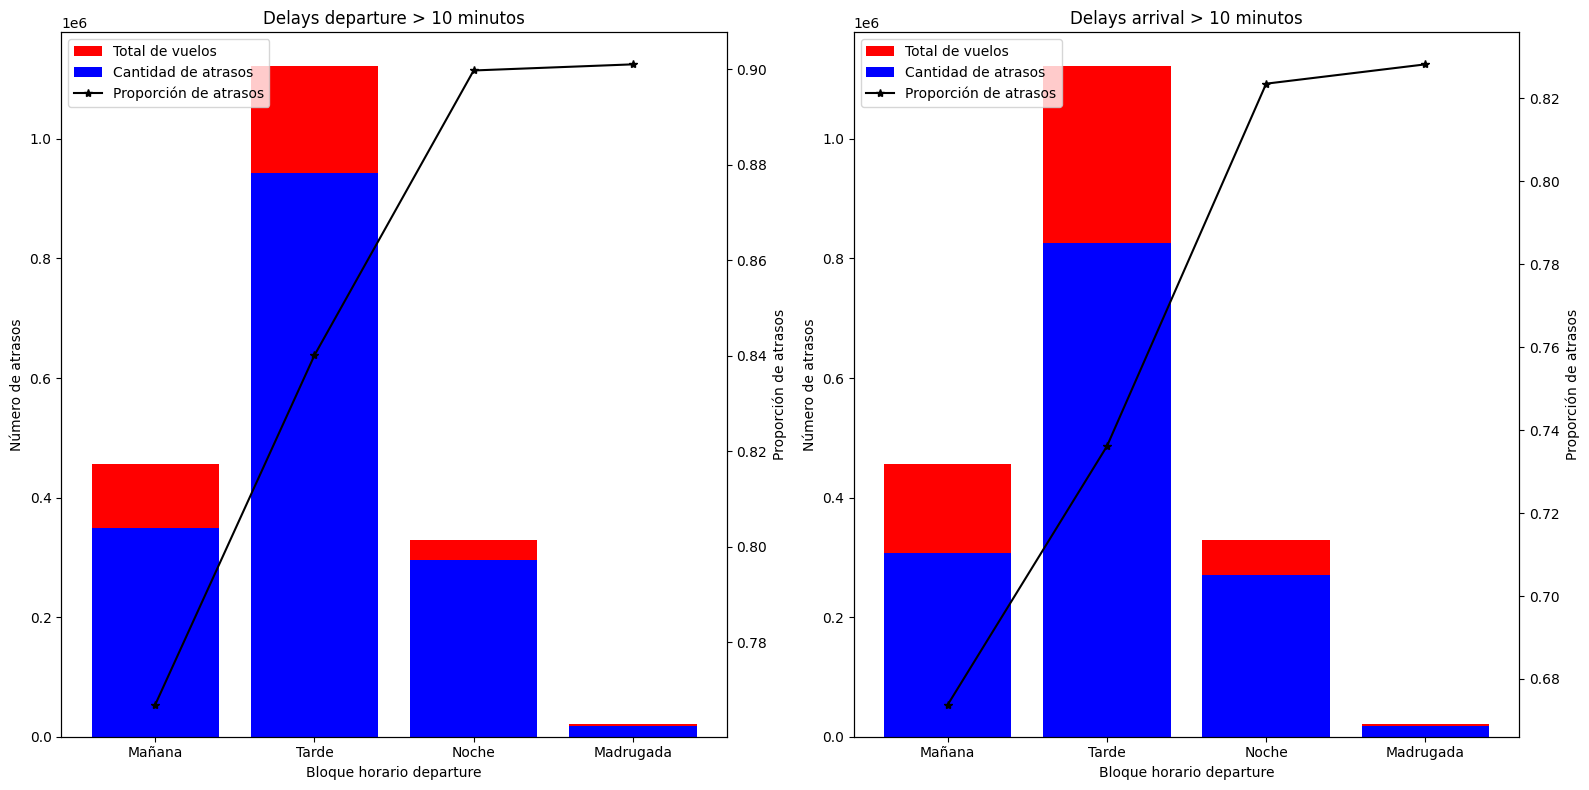

In [19]:
delay_proportion_plot(data, "DepHourBlock4", 10, "Bloque horario departure", dep_only=False)

Si se estudia el mismo efecto, pero con 20 minutos de retraso se puede observar que esta vez las proporciones de vuelos atrasados y no atrasados no es tan desbalanceada como con 10 minutos. La tendencia en los bloques horarios es exactamente la misma, donde se posee menos de un 50% de retrasos en el horario de mañana y aprox. un 80% en madrugada

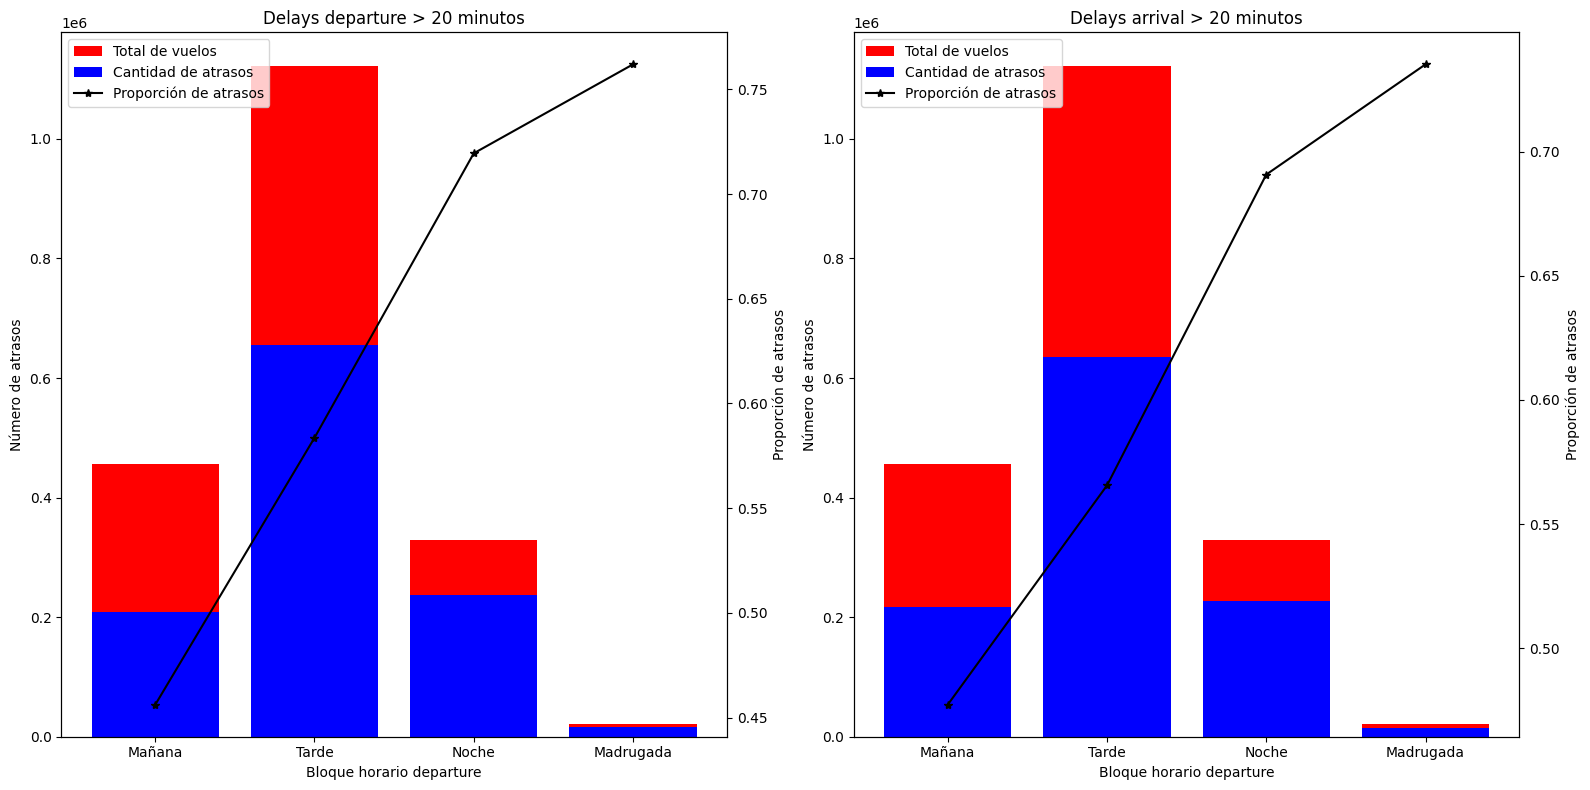

In [20]:
delay_proportion_plot(data, "DepHourBlock4", 20, "Bloque horario departure", dep_only=False)

Para 30 minutos de atraso, se puede ver que ahora la proporción de atrasos por categoría ya no es tan abrupta como con 10 minutos y permite mantener la tendencia en los distintos bloques horarios. La tendencia es nuevamente en madrugada los mayores retrasos con más de un 65% y en el bloque de mañana se tienen los menores retrasos < 35%. De entre los 3 gráficos vistos hasta aquí, con 30 minutos es donde se marcan mayores diferencias entre bloques horarios y además por categoría ya no se tienen un número tan alto de retrasos. Se seguirá ocupando en adelante las variables binarias definidas para 30 minutos, dado que permite visualizar de mejor forma los vuelos "anomalos" que tienen un retraso considerable

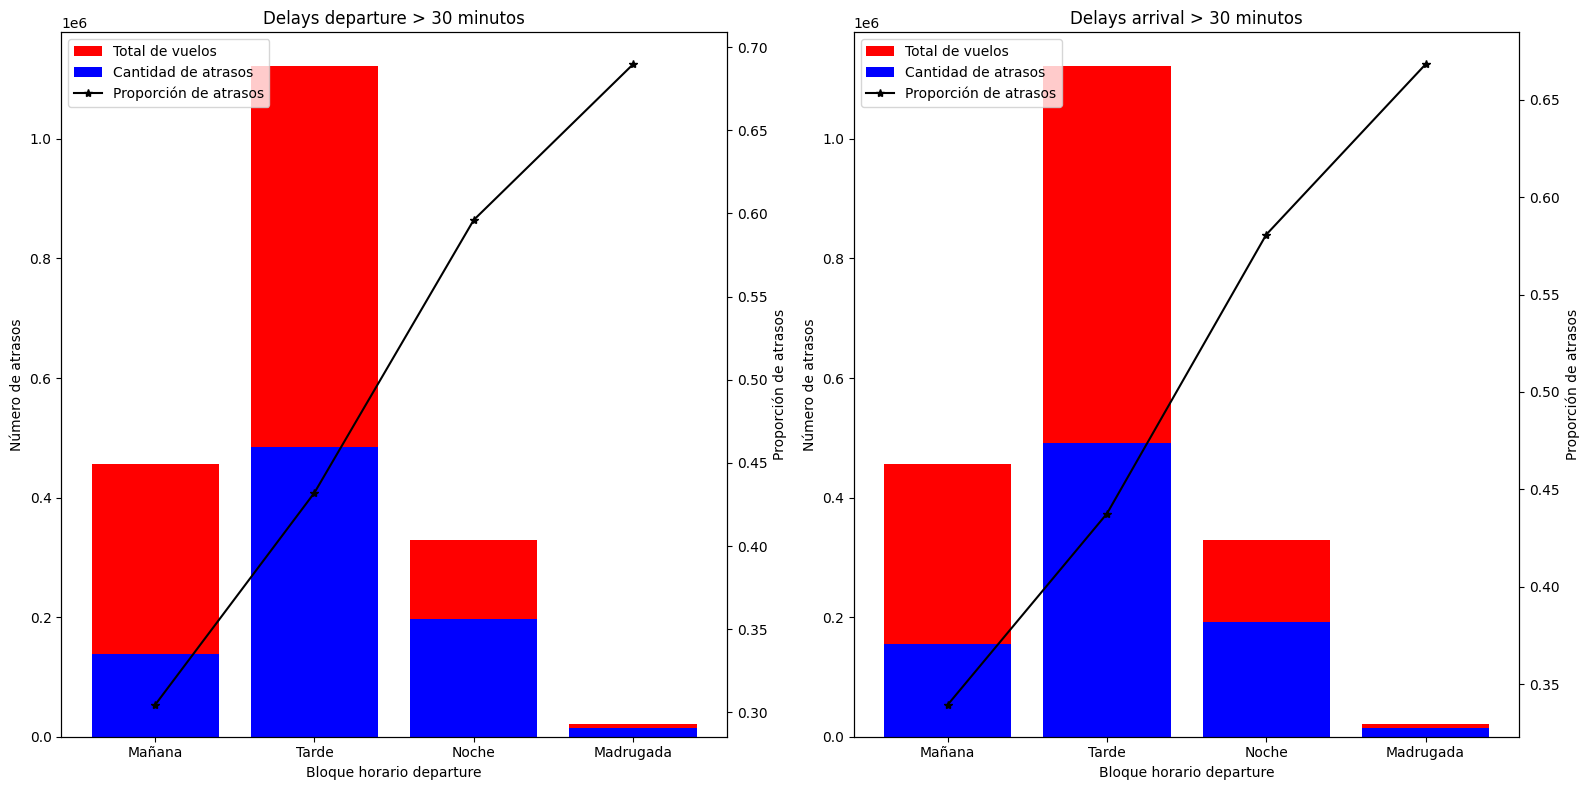

In [21]:
delay_proportion_plot(data, "DepHourBlock4", 30, "Bloque horario departure", dep_only=False)

En el caso del arrival en 4 bloques, se puede ver el mismo comportamiento que en departure con los mayores retrasos en madrugada y menores en el horario de mañana

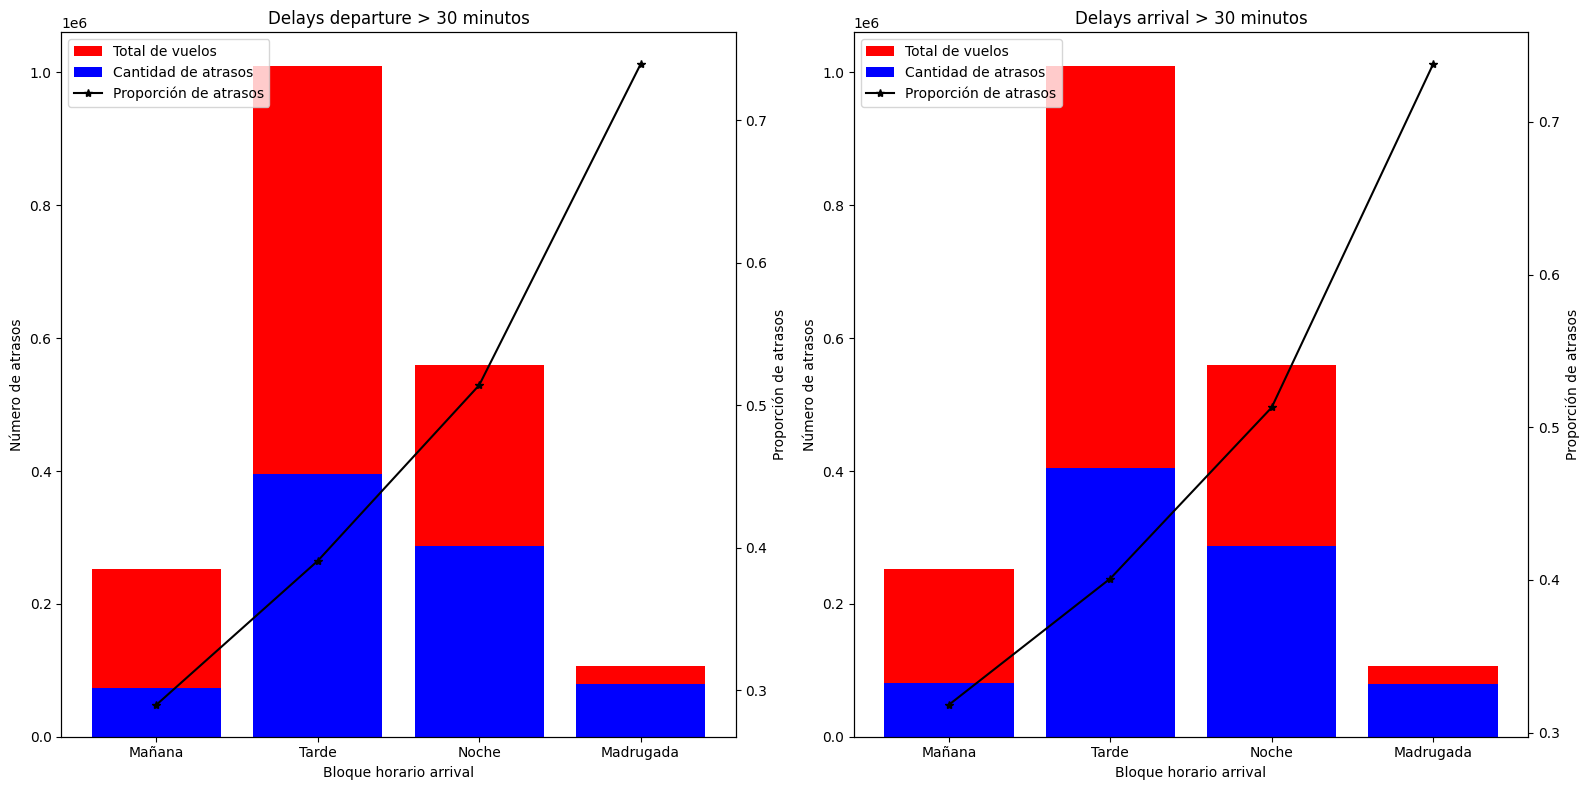

In [22]:
delay_proportion_plot(data, "ArrHourBlock4", 30, "Bloque horario arrival", dep_only=False)

Para las horas definidas en 2 bloques horarios AM y PM, se puede observar que existe una tendencia, pero es mucho menor que con 4 bloques. Notar por ejemplo que en PM se tiene un poco más de un 46% de atrasos, mientras que en AM menos de un 36%. Esta tendencia no es lógica, ya que se vio que en madrugada y noche es donde se marcan más delays y además una diferencia de un 10% entre los 2 bloque no es abrupta como para concluir al respecto

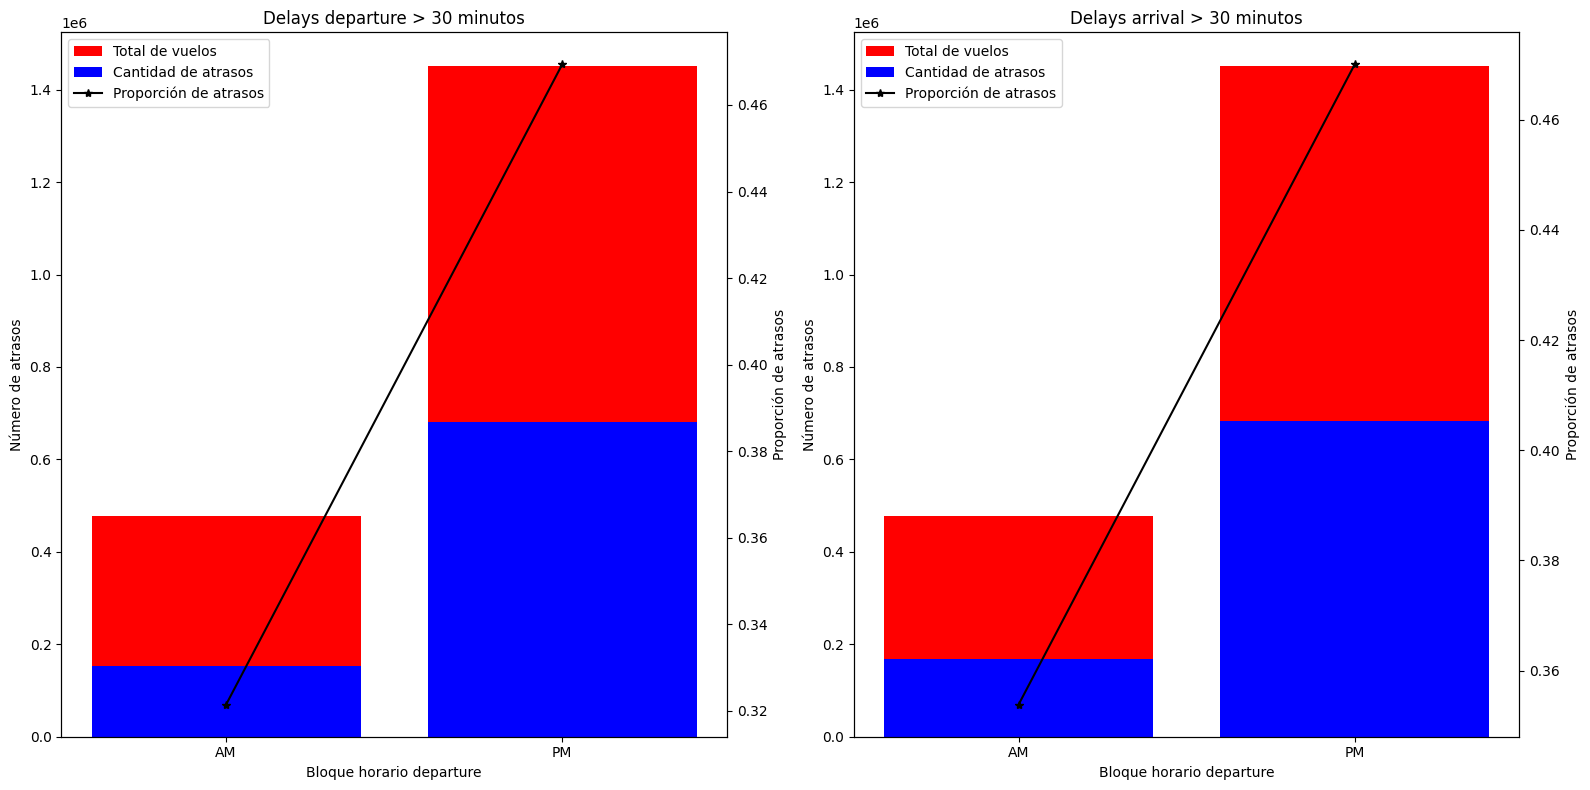

In [18]:
delay_proportion_plot(data, "DepHourBlock2", 30, "Bloque horario departure", dep_only=False)

Para 2 bloques en el arrival análogamente no se tienen diferencias significativas, notando que varían apenas entre 42 y 43%. Se desprender que en general es preferible usar 4 bloques horarios

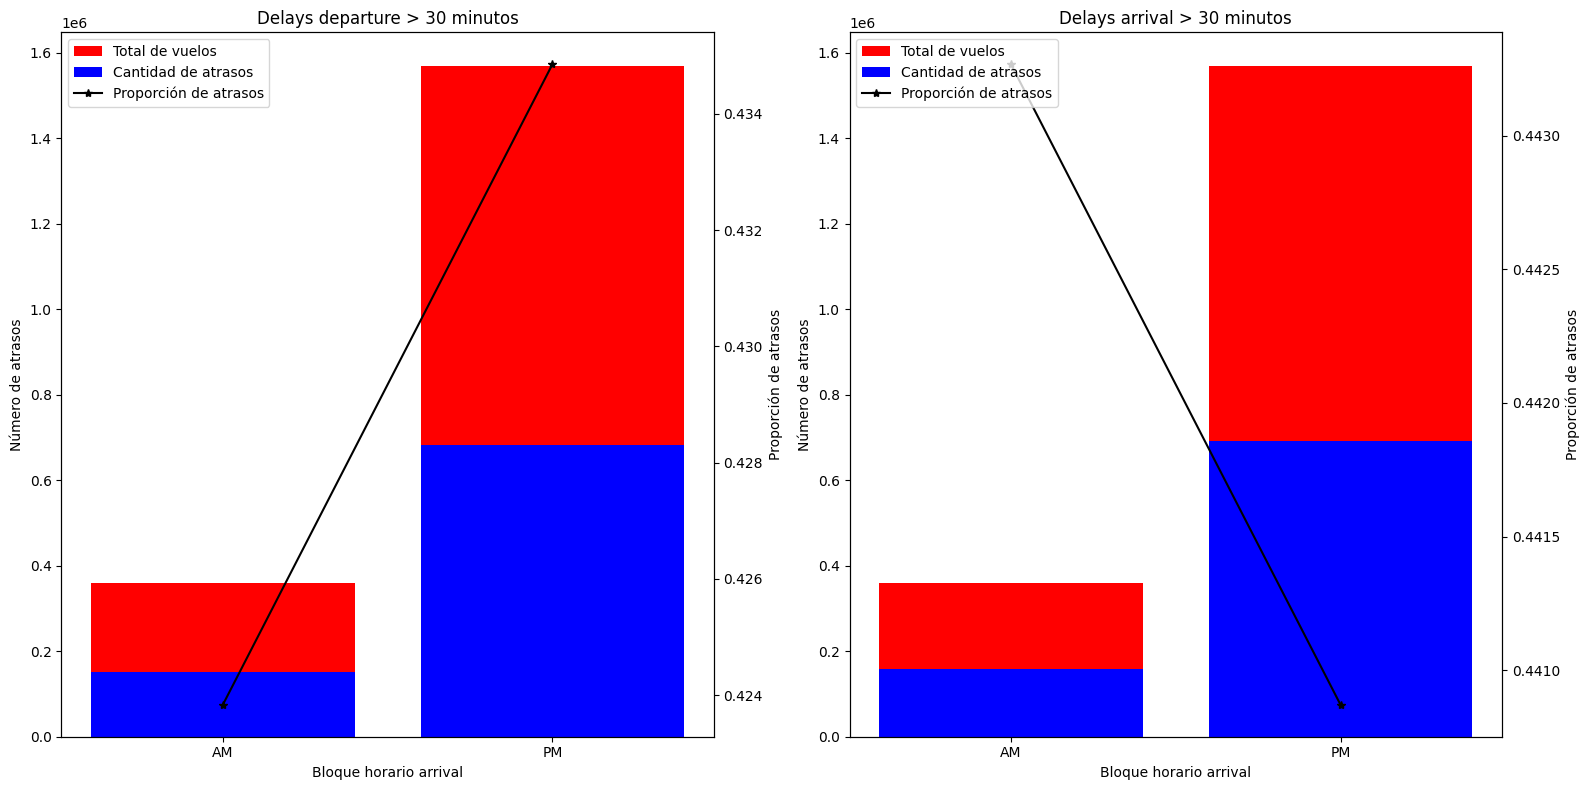

In [17]:
delay_proportion_plot(data, "ArrHourBlock2", 30, "Bloque horario arrival", dep_only=False)

## Por Carrier

Se puede ver que los códigos de aerolínea que concentran mayores retrasos son YV y OH. Los menores se dan en AQ, F9 y HA. Los porcentajes varían entre un 25% aprox hasta más de un 65%, por lo que si hay diferencias significativas entre aerolíneas

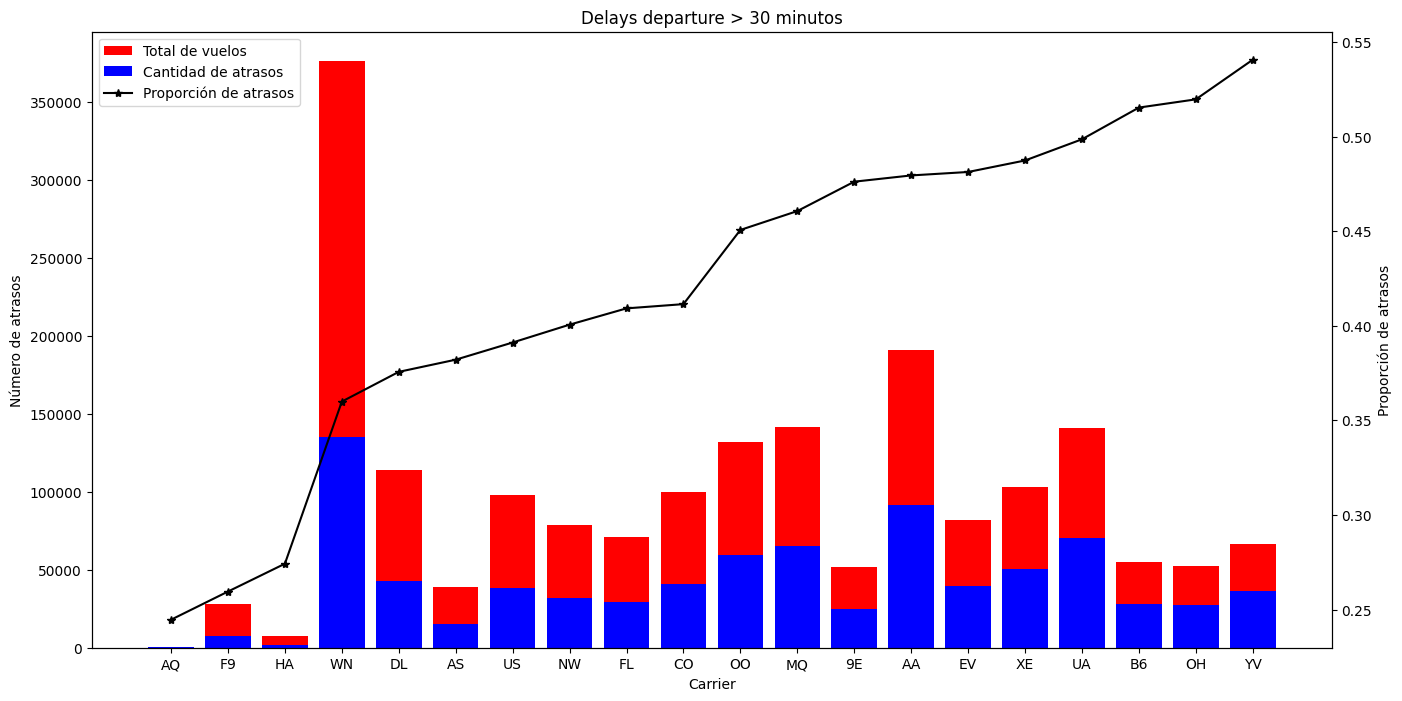

In [24]:
delay_proportion_plot(data, "UniqueCarrier", 30, "Carrier", dep_only=True)

## Por fecha del vuelo

Los mayores retrasos se dan en Diciembre y los menores en octubre. Se marca una tendencia, pero no es tan significativa como en otras variables, aprox entre un 34 y 48% de atrasos

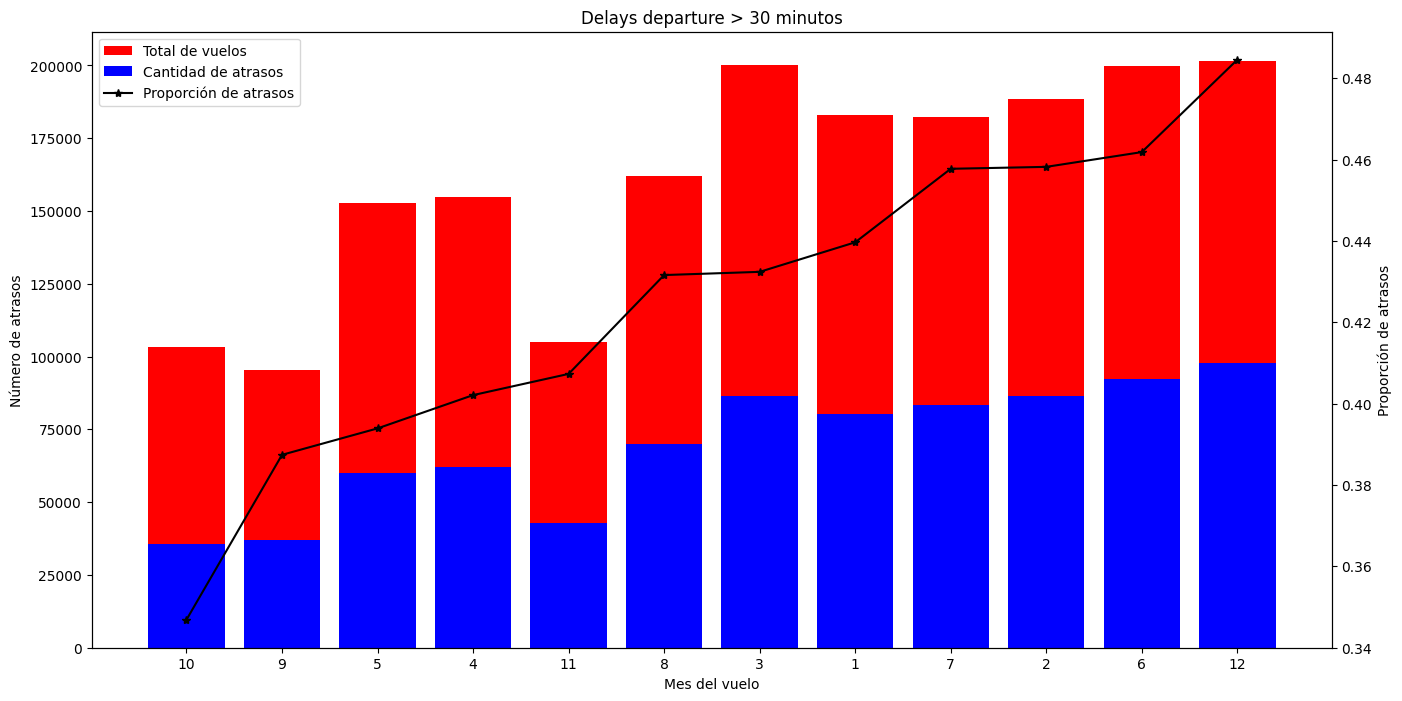

In [25]:
delay_proportion_plot(data, "Month", 30, "Mes del vuelo", dep_only=True)

Se marcan mayores retrasos el 31 de mes, pero igual que en el gráfico anterior las diferencias no son tan grandes como en los bloques horarios por ejemplo

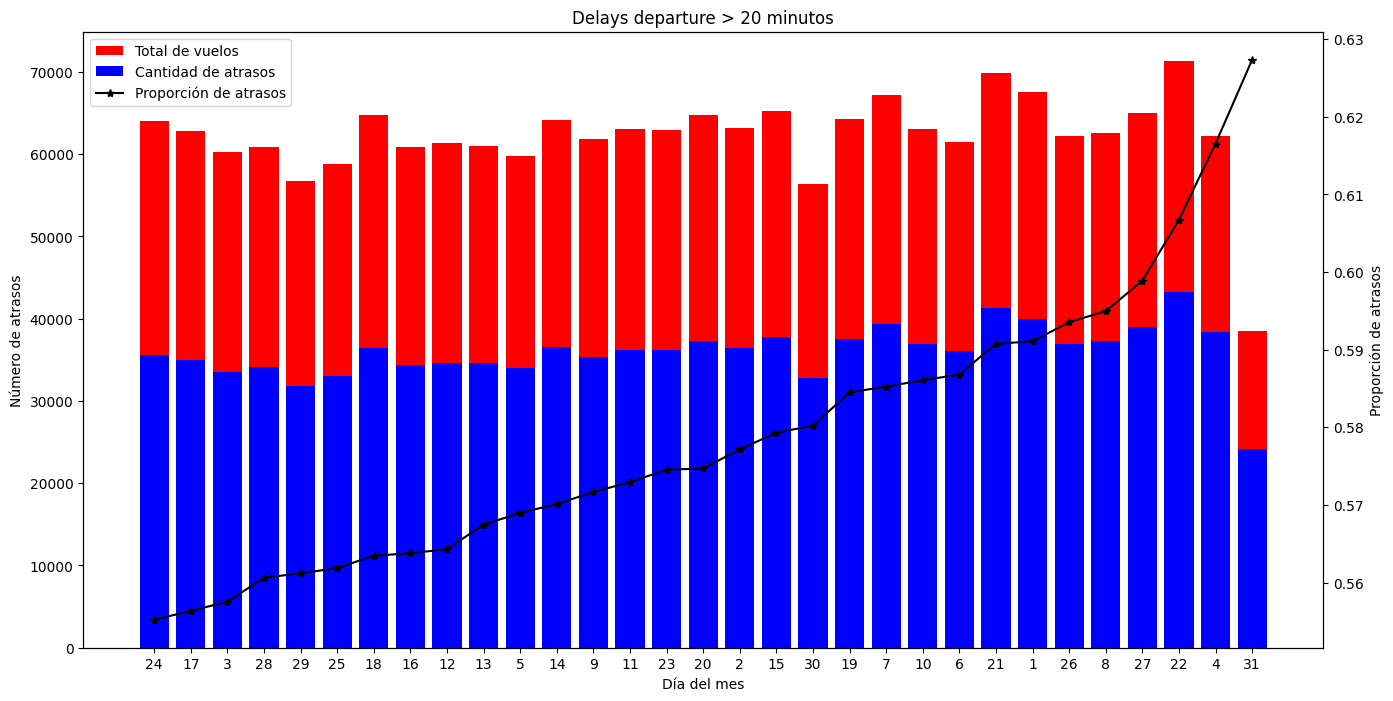

In [88]:
delay_proportion_plot(data, "DayofMonth", 20, "Día del mes", dep_only=True)

Se puede ver que aparentemente hay tendencias con el día de la semana, pero las diferencias porcentuales son muy pequeñas aprox entre un 56 y un 59%. Esta variable se desprende que no es discriminativa con la variable de retraso o delay

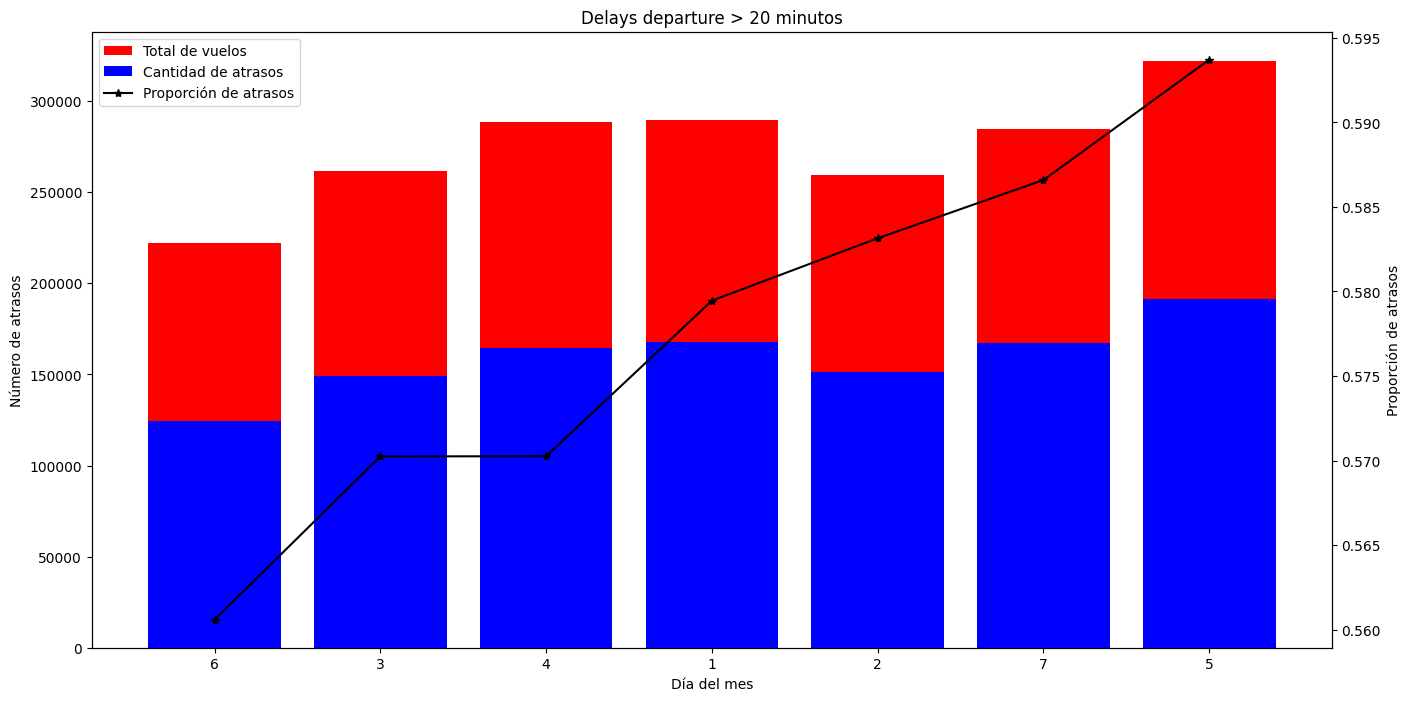

In [89]:
delay_proportion_plot(data, "DayOfWeek", 20, "Día del mes", dep_only=True)